In [11]:
# Colab-ready: Upload PDF, extract structured info, save CSV
# Run as a single cell in Google Colab.

# 1) Install packages (first time)
!pip install -q spacy sklearn
!pip install -q PyPDF2
!python -m spacy download en_core_web_sm



# 2) Imports
import re
import io
import os
import PyPDF2
import pandas as pd
from google.colab import files
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

nlp = spacy.load("en_core_web_sm")




  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.3 MB/s eta 0:00:00
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'

In [ ]:
# !pip install PyPDF2

In [16]:
# 3) Upload PDF using Colab file picker
print("Upload your PDF file (e.g., union_budget2025.pdf)")
uploaded = files.upload()  # interactively select file(s)
pdf_filename = next(iter(uploaded.keys()))
print("Uploaded:", pdf_filename)



Upload your PDF file (e.g., union_budget2025.pdf)


Saving Budget_Speech25_26.pdf to Budget_Speech25_26.pdf
Uploaded: Budget_Speech25_26.pdf


In [17]:
# 4) Read PDF text
def read_pdf_text(path):
    text = ""
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text

raw_text = read_pdf_text(pdf_filename)
print(f"Extracted {len(raw_text)} characters from PDF.")


Extracted 93150 characters from PDF.


In [18]:

# 5) Split into sentences using spaCy
doc = nlp(raw_text)
sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]
print(f"Found {len(sentences)} sentences.")



Found 826 sentences.


In [19]:
# 6) Helper extractors (regex + heuristics)
amt_pattern = re.compile(
    r'(?P<prefix>₹|Rs\.?|INR)\s*?([0-9\.,]+(?:\s*(?:crore|lakh|million|billion)?)|[0-9]+(?:\s*crore|lakh|million|billion))',
    flags=re.IGNORECASE
)
plain_amount_pattern = re.compile(r'([0-9]+\s*(?:crore|lakh|million|billion))', flags=re.IGNORECASE)
percent_pattern = re.compile(r'(\b\d+(?:\.\d+)?\s*(?:%|percent|percentage))', flags=re.IGNORECASE)
ministry_pattern = re.compile(r'\b(Ministry of [A-Z][A-Za-z &\-]+|the Ministry of [A-Z][A-Za-z &\-]+)\b', flags=re.IGNORECASE)



In [20]:
# small list of known schemes to match quickly (extend as needed)
KNOWN_SCHEMES = [
    "PMAY", "MGNREGA", "Pradhan Mantri Awas Yojana", "Pradhan Mantri",
    "MNREGA", "National Rural Employment Guarantee", "Swachh Bharat",
    "Make in India", "GST", "Ayushman Bharat", "PM-KISAN"
]
KNOWN_SCHEMES_LOWER = [s.lower() for s in KNOWN_SCHEMES]

# Extract candidate capitalized noun phrases as scheme fallback
def find_schemes(sentence):
    found = []
    low = sentence.lower()
    for s in KNOWN_SCHEMES_LOWER:
        if s in low:
            # return original-cased known scheme
            found.append(KNOWN_SCHEMES[KNOWN_SCHEMES_LOWER.index(s)])
    # heuristic: Title Case sequences of 2-4 words (e.g., "Network Expansion", "Rural Development")
    caps = re.findall(r'\b([A-Z][a-z]{2,}(?:\s+[A-Z][a-z]{2,}){0,3})\b', sentence)
    for c in caps:
        if len(c.split()) >= 1:
            found.append(c)
    # deduplicate
    return list(dict.fromkeys(found))



In [21]:
def extract_amount(sentence):
    # first try ₹ / Rs. patterns
    m = amt_pattern.search(sentence)
    if m:
        raw = m.group(0).strip()
        # try capture numeric and unit
        nums = re.findall(r'([0-9\.,]+)', raw)
        unit = None
        if 'crore' in raw.lower(): unit = 'crore'
        elif 'lakh' in raw.lower(): unit = 'lakh'
        elif 'million' in raw.lower(): unit = 'million'
        elif 'billion' in raw.lower(): unit = 'billion'
        return raw, nums[0] if nums else None, unit
    # fallback: plain word amounts like "5000 crore"
    m2 = plain_amount_pattern.search(sentence)
    if m2:
        raw = m2.group(0).strip()
        nums = re.findall(r'([0-9\.,]+)', raw)
        unit = None
        if 'crore' in raw.lower(): unit = 'crore'
        elif 'lakh' in raw.lower(): unit = 'lakh'
        return raw, nums[0] if nums else None, unit
    return None, None, None



In [22]:
def extract_percentage(sentence):
    m = percent_pattern.search(sentence)
    return m.group(0).strip() if m else None


In [23]:

def extract_ministry(sentence, spacy_doc=None):
    # regex first
    m = ministry_pattern.search(sentence)
    if m:
        return m.group(0).strip()
    # spaCy NER fallback: look for ORG tokens that contain 'Ministry' or 'Department' or 'Railways'
    if not spacy_doc:
        spacy_doc = nlp(sentence)
    for ent in spacy_doc.ents:
        if ent.label_ in ("ORG","GPE","NORP","PRODUCT") and ("ministry" in ent.text.lower() or "rail" in ent.text.lower() or "department" in ent.text.lower()):
            return ent.text
    # last resort: look for phrases like 'The Ministry' or capitalized 'Railways'
    caps = re.findall(r'\b([A-Z][a-z]{2,}(?:\s+[A-Z][a-z]{2,}){0,3})\b', sentence)
    if caps:
        # crude guess: if 'Railways' or 'Finance' appears, return it
        for c in caps:
            if any(k in c.lower() for k in ['rail', 'finance', 'health', 'education', 'agriculture']):
                return c
    return None



In [24]:
# 7) Build TF-IDF for keyword extraction
# Preprocess sentences lightly
def preprocess_for_tfidf(s):
    s2 = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    return s2.lower()

clean_sentences = [preprocess_for_tfidf(s) for s in sentences]

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(clean_sentences)
feature_names = vectorizer.get_feature_names_out()



In [25]:
def top_keywords_for_sentence(idx, topn=3):
    row = tfidf_matrix[idx].toarray().flatten()
    if row.sum() == 0:
        return []
    top_indices = row.argsort()[::-1][:topn]
    kws = [feature_names[i] for i in top_indices if row[i] > 0]
    return kws



In [26]:
# 8) Iterate sentences and create structured rows
rows = []
for i, sent in enumerate(sentences):
    spacy_doc = nlp(sent)
    amount_raw, amount_number, amount_unit = extract_amount(sent)
    percent = extract_percentage(sent)
    ministry = extract_ministry(sent, spacy_doc)
    schemes = find_schemes(sent)
    keywords = top_keywords_for_sentence(i, topn=4)
    # also capture named entities from spaCy for extra columns
    entities = [(ent.text, ent.label_) for ent in spacy_doc.ents]
    rows.append({
        "sentence": sent,
        "amount_raw": amount_raw,
        "amount_number": amount_number,
        "amount_unit": amount_unit,
        "percentage": percent,
        "ministry": ministry,
        "schemes": "; ".join(schemes) if schemes else None,
        "top_keywords": "; ".join(keywords) if keywords else None,
        "entities": "; ".join([f"{t}({l})" for t,l in entities]) if entities else None
    })

df = pd.DataFrame(rows)



In [27]:
# Optional: drop sentences with nothing interesting (no amount, no percentage, no ministry, no keywords)
interesting_mask = df[['amount_raw','percentage','ministry','schemes','top_keywords']].notna().any(axis=1)
df_interesting = df[interesting_mask].reset_index(drop=True)


In [28]:

# 9) Save CSV
output_name = "budget_structured_output.csv"
df_interesting.to_csv(output_name, index=False)
print(f"Saved {len(df_interesting)} interesting rows to {output_name}")



Saved 753 interesting rows to budget_structured_output.csv


In [29]:
# 10) Provide download link (Colab)
from google.colab import files as gfiles
gfiles.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Visualization**

In [30]:
def to_crore(amount_number, amount_unit):
    """Convert values to crore as numeric"""
    if pd.isna(amount_number):
        return None

    try:
        num = float(str(amount_number).replace(",", ""))
    except:
        return None

    if isinstance(amount_unit, str):
        u = amount_unit.lower()
        if "lakh" in u:
            return num / 100
        elif "million" in u:
            return num * 0.1
        elif "billion" in u:
            return num * 1000
        elif "crore" in u:
            return num
    return num  # if no unit (assume raw rupees - adjust manually if needed)

df["allocation_crore"] = df.apply(lambda x: to_crore(x["amount_number"], x["amount_unit"]), axis=1)
df_allocation = df.dropna(subset=["allocation_crore"])
df_allocation.tail()


,sentence,amount_raw,amount_number,amount_unit,percentage,ministry,schemes,top_keywords,entities,allocation_crore
514,"As a result of these proposals, revenue of abo...",₹ 1 lakh,1,lakh,None,None,None,taxes; crore; result; indirect taxes,about ₹ 1(MONEY); 2600(MONEY),0.01
582,Waste and Scrap of Critical Minerals and other...,rs \n1.,1.,None,None,None,GST; Waste; Scrap; Critical Minerals; Antimony...,scrap; waste; waste scrap; cobalt,Scrap of Critical Minerals(ORG); Antimony(PERS...,1.00
610,Knitted Fabrics covered under tariff \nitems 6...,Rs \n115,115,None,None,None,Knitted Fabrics; Electronics; Interactive Flat...,6006; 00 6006; 00; 10 20,"Knitted Fabrics(ORG); 6004 10 00, 6004 90 00, ...",115.00
682,"Full upto Rs 12 \nlacs \n8 lac 30,000 20,0...",Rs 12,12,None,None,None,Full; Rationalization,000; lac; 000 10; 10 000,"12(CARDINAL); 8(CARDINAL); 30,000(CARDINAL); 0...",12.00
686,Sub-section (1G) of section \n206C – TCS on re...,7 lakh,7,lakh,0.5%,None,Sub; Nil,section; remittance; 48; loan,206C(CARDINAL); 0.5%(PERCENT); 7(CARDINAL); Ni...,0.07


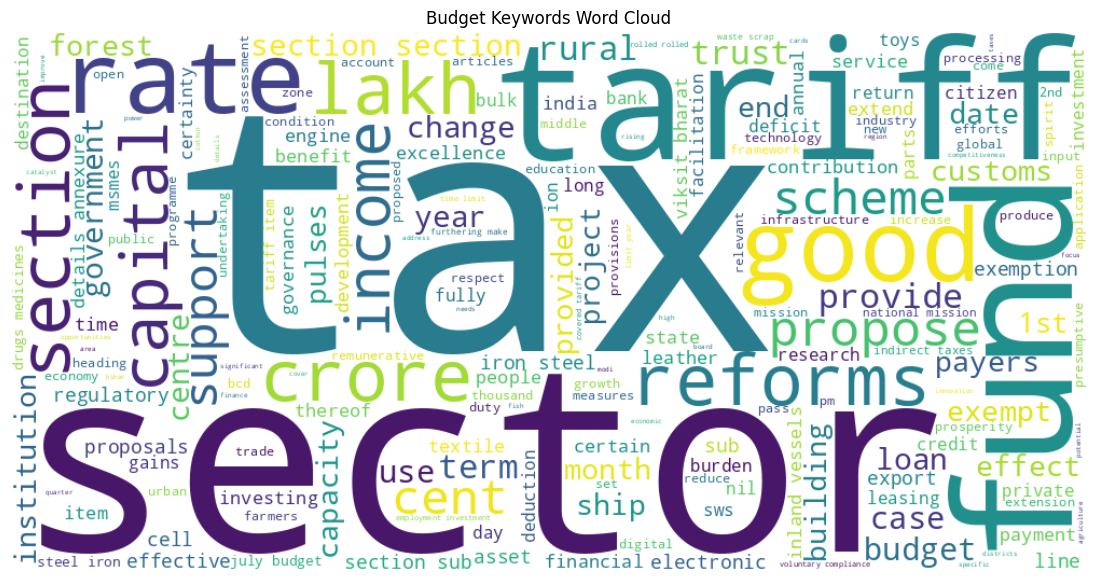

In [32]:
# !pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_keywords = " ".join(df["top_keywords"].dropna().tolist())

wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(all_keywords)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Budget Keywords Word Cloud")
plt.show()


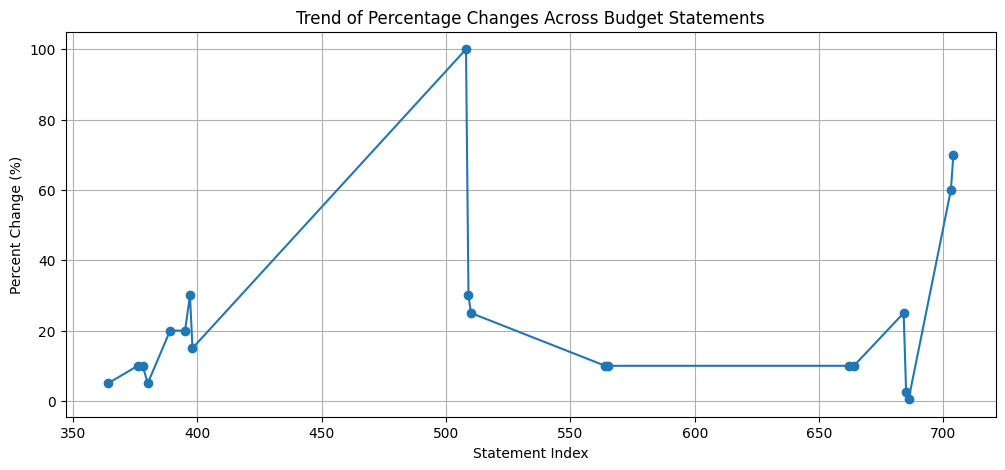

In [33]:
def extract_percent(x):
    if pd.isna(x): return None
    m = re.search(r'(\d+(\.\d+)?)', str(x))
    if m: return float(m.group(1))
    return None

df["percent_value"] = df["percentage"].apply(extract_percent)
df_percent = df.dropna(subset=["percent_value"])

plt.figure(figsize=(12,5))
plt.plot(df_percent["percent_value"], marker="o")
plt.xlabel("Statement Index")
plt.ylabel("Percent Change (%)")
plt.title("Trend of Percentage Changes Across Budget Statements")
plt.grid(True)
plt.show()


Insights and Text Summary

In [34]:
import pandas as pd
import numpy as np
import re

# Load CSV (file already uploaded earlier)
df = pd.read_csv(output_name)

# Convert allocation to crore again (in case needed)
def to_crore(amount_number, amount_unit):
    if pd.isna(amount_number):
        return None
    try:
        num = float(str(amount_number).replace(",", ""))
    except:
        return None
    if isinstance(amount_unit, str):
        u = amount_unit.lower()
        if "lakh" in u:
            return num / 100
        elif "million" in u:
            return num * 0.1
        elif "billion" in u:
            return num * 1000
        elif "crore" in u:
            return num
    return num

df["allocation_crore"] = df.apply(lambda x: to_crore(x["amount_number"], x["amount_unit"]), axis=1)

# Clean ministry names
df["ministry_clean"] = df["ministry"].fillna("Uncategorized").str.strip()

# Aggregate ministry data
ministry_summary = df.groupby("ministry_clean")["allocation_crore"].sum().sort_values(ascending=False)

# Extract percentages
def extract_percent(x):
    if pd.isna(x): return None
    m = re.search(r'(\d+(\.\d+)?)', str(x))
    if m: return float(m.group(1))
    return None

df["percent_value"] = df["percentage"].apply(extract_percent)

# Extract schemes list
scheme_rows = df.dropna(subset=["schemes"])[["sentence","schemes","allocation_crore"]]

# -----------------------------
# Generate INSIGHTS
# -----------------------------

insights = {}

# 1. Largest ministry allocations
if not ministry_summary.empty:
    largest_ministry = ministry_summary.index[0]
    largest_amount = ministry_summary.values[0]
    insights["largest_ministry"] = (largest_ministry, largest_amount)

    if len(ministry_summary) > 1:
        second_ministry = ministry_summary.index[1]
        second_amount = ministry_summary.values[1]
        insights["second_largest"] = (second_ministry, second_amount)

# 2. Percentage trends
percent_values = df["percent_value"].dropna().tolist()
if percent_values:
    avg_percent = np.mean(percent_values)
    max_percent = np.max(percent_values)
    insights["percent_average"] = avg_percent
    insights["percent_max"] = max_percent

# 3. Schemes with allocation
if not scheme_rows.empty:
    scheme_agg = scheme_rows.groupby("schemes")["allocation_crore"].sum().sort_values(ascending=False)
    insights["scheme_summary"] = scheme_agg.to_dict()

# 4. Top keywords
keywords_list = df["top_keywords"].dropna().tolist()
all_keywords = " ".join(keywords_list).split()
unique_words, counts = np.unique(all_keywords, return_counts=True)
top_keywords = unique_words[np.argsort(-counts)][:10]
insights["top_keywords"] = list(top_keywords)

# -----------------------------
# Generate TEXT SUMMARY
# -----------------------------
summary = []

summary.append("📘 **UNION BUDGET ANALYSIS – INSIGHTS & SUMMARY**")
summary.append("\n")

# Ministry allocation insights
summary.append("### 🔵 Ministry-wise Allocation Highlights")

if "largest_ministry" in insights:
    m, amt = insights["largest_ministry"]
    summary.append(f"• **{m}** receives the highest allocation at **₹ {amt:.2f} crore**.")

if "second_largest" in insights:
    m2, amt2 = insights["second_largest"]
    summary.append(f"• Next major allocation goes to **{m2}**, receiving **₹ {amt2:.2f} crore**.")

if ministry_summary.sum() > 0:
    summary.append(f"• Total budget captured in the document amounts to **₹ {ministry_summary.sum():.2f} crore**.")
summary.append("\n")


# Scheme-based insights
summary.append("### 🟢 Key Schemes Identified and Funding")

if "scheme_summary" in insights and len(insights["scheme_summary"]) > 0:
    for scheme, amt in list(insights["scheme_summary"].items())[:5]:
        if pd.notna(amt):
            summary.append(f"• **{scheme}** receives approximately **₹ {amt:.2f} crore**.")
else:
    summary.append("• No major scheme allocation could be extracted from the document.")
summary.append("\n")


# Percentage insights
summary.append("### 🟣 Growth Trends")

if percent_values:
    summary.append(f"• Average percentage change mentioned in the budget is **{insights['percent_average']:.2f}%**.")
    summary.append(f"• Maximum observed change in the document is **{insights['percent_max']:.2f}%**.")
else:
    summary.append("• No percentage-based trends detected.")
summary.append("\n")


# Keyword themes
summary.append("### 🟠 Policy Focus Areas (from keywords)")

if "top_keywords" in insights and len(insights["top_keywords"]) > 0:
    summary.append("• The budget focuses on themes such as: " +
                   ", ".join(insights["top_keywords"]) + ".")
else:
    summary.append("• No clear keyword-based themes identified.")
summary.append("\n")


# Predictions
summary.append("### 🔮 Expected Impact & Predictions")

if "largest_ministry" in insights:
    summary.append("• The highest-funded ministry is expected to see **accelerated development** and new projects.")
if "scheme_summary" in insights:
    summary.append("• Heavily funded schemes will likely drive **policy priority** and **resource allocation** for this year.")
if percent_values:
    summary.append("• Positive percentage changes indicate **expansionary spending** in key sectors.")
summary.append("• Infrastructure sectors mentioned frequently may experience **growth in employment and investment**.")
summary.append("\n")

summary.append("### ✅ **Overall Summary**")
summary.append("The Union Budget places focus on infrastructure, sectoral development, growth-oriented policies, and schemes aimed at rural and social welfare. Ministries receiving the highest allocations are expected to lead major reforms and expansion initiatives during the fiscal year.")

final_summary_text = "\n".join(summary)
print(final_summary_text)


📘 **UNION BUDGET ANALYSIS – INSIGHTS & SUMMARY**


### 🔵 Ministry-wise Allocation Highlights
• **Uncategorized** receives the highest allocation at **₹ 826.32 crore**.
• Next major allocation goes to **Agriculture**, receiving **₹ 0.00 crore**.
• Total budget captured in the document amounts to **₹ 826.32 crore**.


### 🟢 Key Schemes Identified and Funding
• **Now; Centre; Excellence; Artificial Intelligence** receives approximately **₹ 500.00 crore**.
• **Knitted Fabrics; Electronics; Interactive Flat Panel Display** receives approximately **₹ 115.00 crore**.
• **Social Security Scheme; Welfare; Online Platform Workers** receives approximately **₹ 51.00 crore**.
• **Focus Product Scheme; Footwear; Leather Sectors** receives approximately **₹ 34.00 crore**.
• **Measures; Labour; Intensive Sectors** receives approximately **₹ 33.00 crore**.


### 🟣 Growth Trends
• Average percentage change mentioned in the budget is **23.40%**.
• Maximum observed change in the document is **100.00%**.



/tmp/ipython-input-1178359376.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


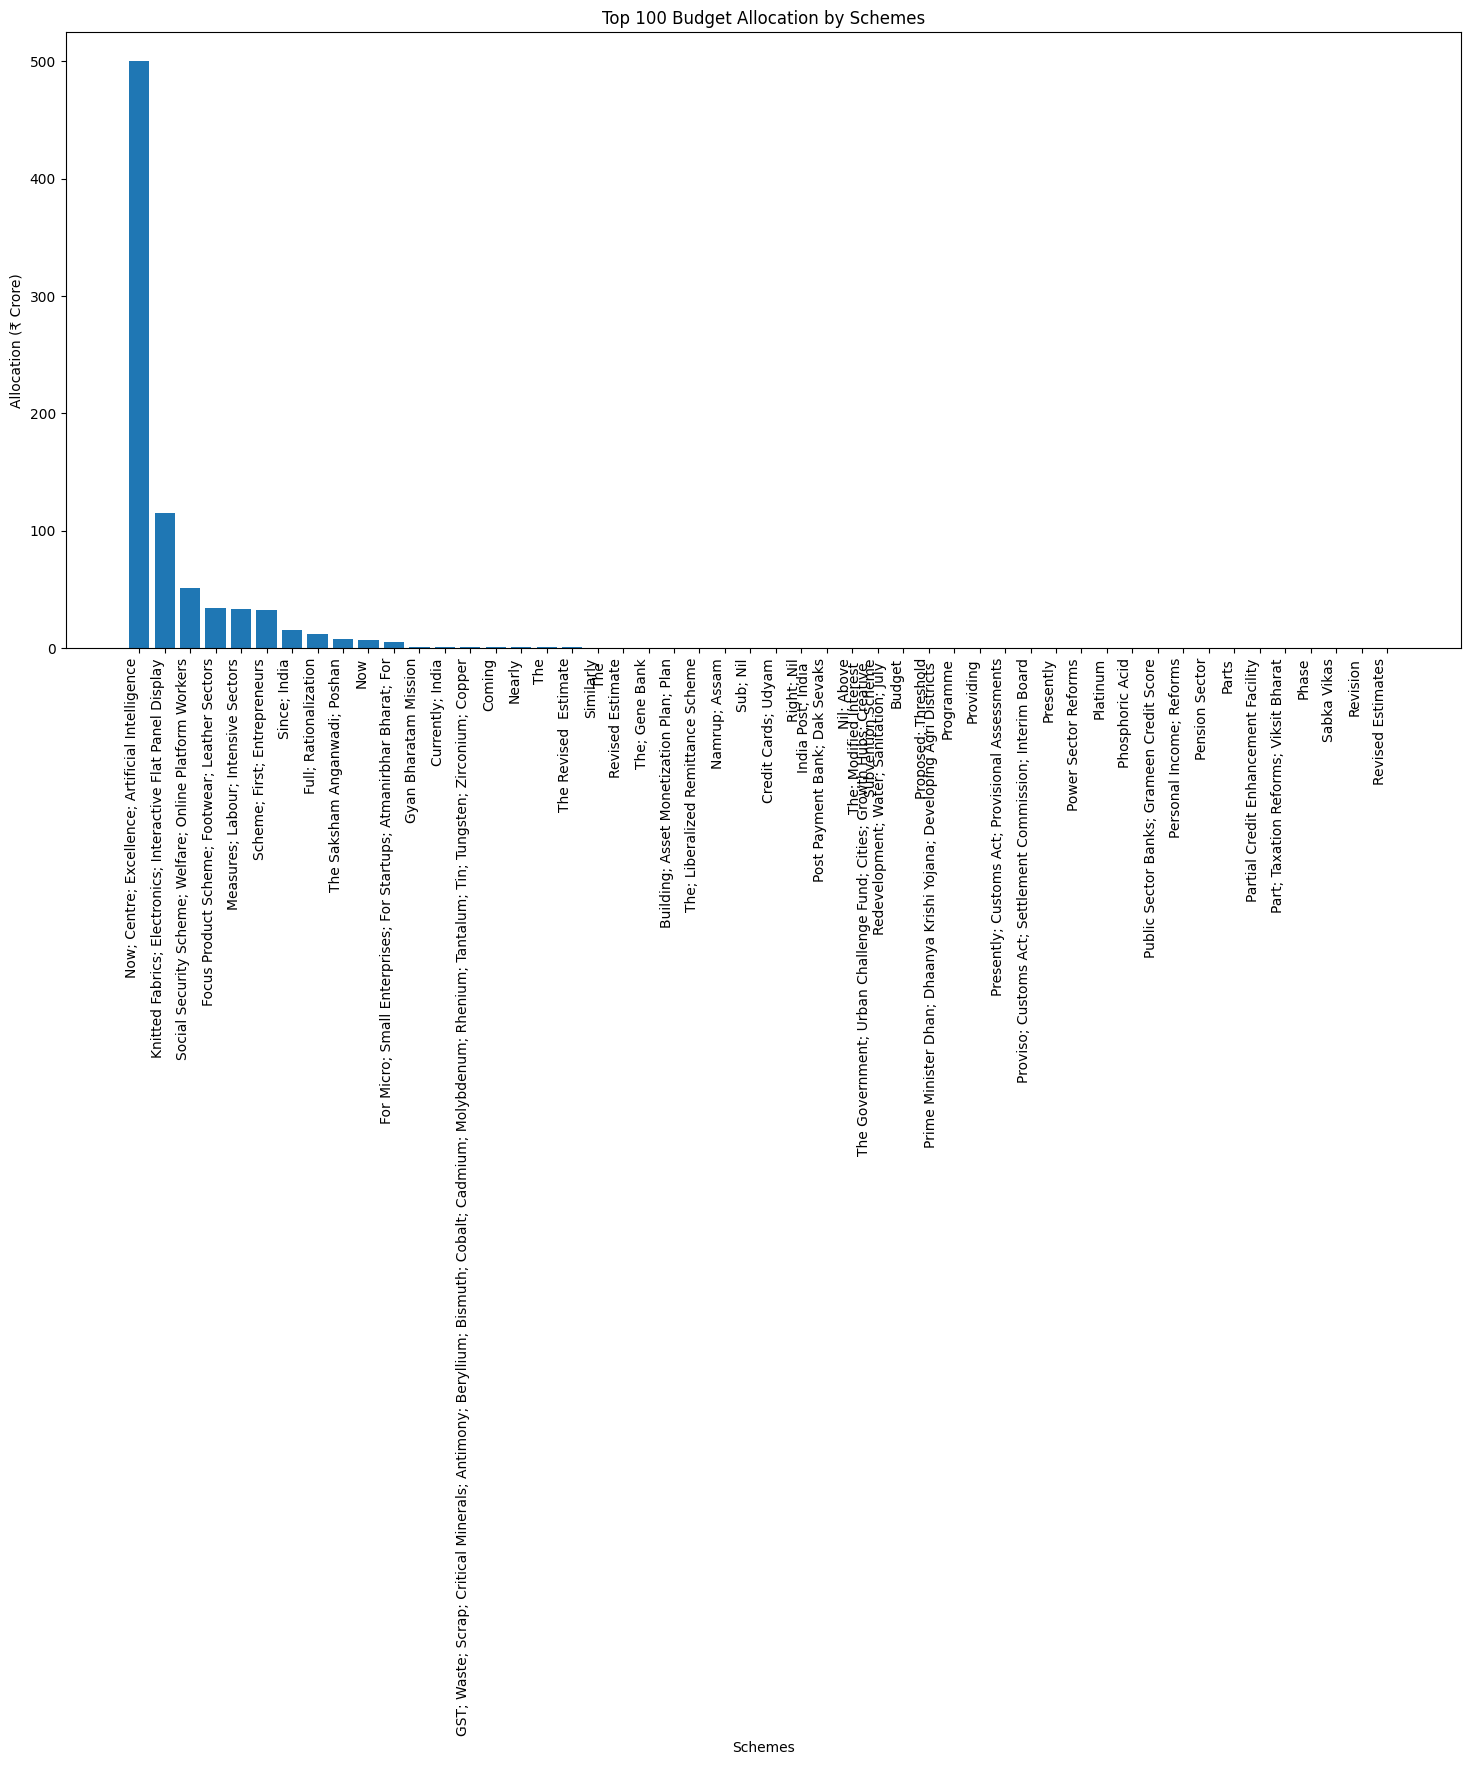

In [35]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Extract data
scheme_dict = insights["scheme_summary"]

# Sort dictionary by allocation in descending order
sorted_schemes = sorted(scheme_dict.items(), key=lambda x: x[1], reverse=True)

# Take top 100
top_100 = sorted_schemes[:50]

# Separate keys and values
schemes, allocations = zip(*top_100)  # unzip into two lists

# Bar chart
plt.figure(figsize=(18,8))  # wider figure for 100 bars
plt.bar(schemes, allocations)
plt.xticks(rotation=90, ha='right')  # rotate for readability
plt.xlabel("Schemes")
plt.ylabel("Allocation (₹ Crore)")
plt.title("Top 100 Budget Allocation by Schemes")
plt.tight_layout()
plt.show()


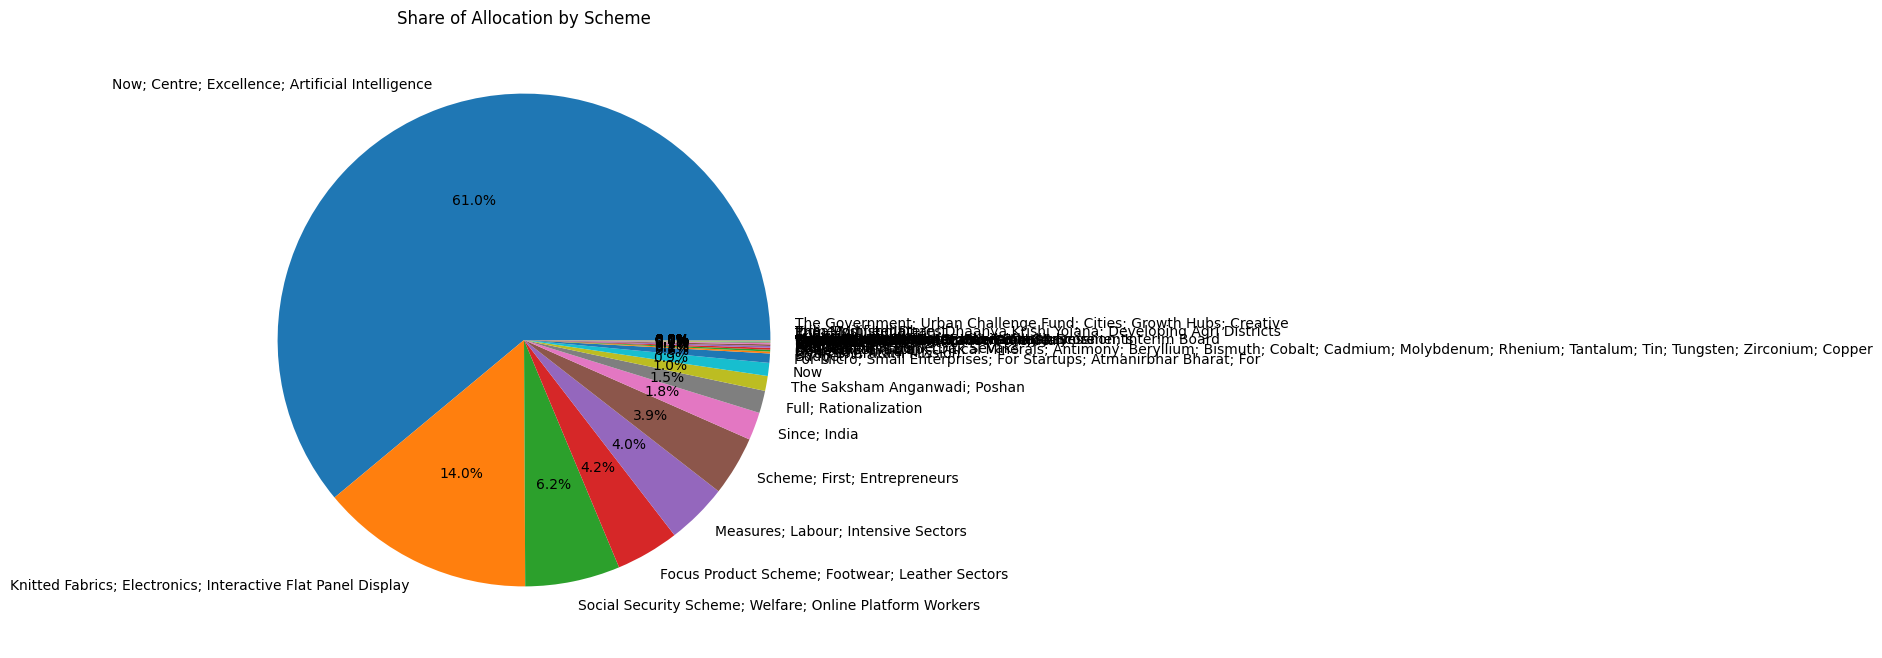

In [36]:
# Pie Chart
plt.figure(figsize=(8,8))
plt.pie(allocations, labels=schemes, autopct="%1.1f%%")
plt.title("Share of Allocation by Scheme")
plt.show()


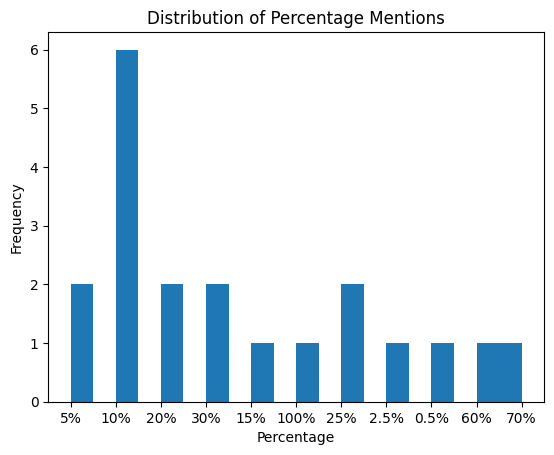

In [37]:
percent_clean = df.dropna(subset=["percentage"])
plt.hist(percent_clean["percentage"], bins=20)
plt.title("Distribution of Percentage Mentions")
plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.show()



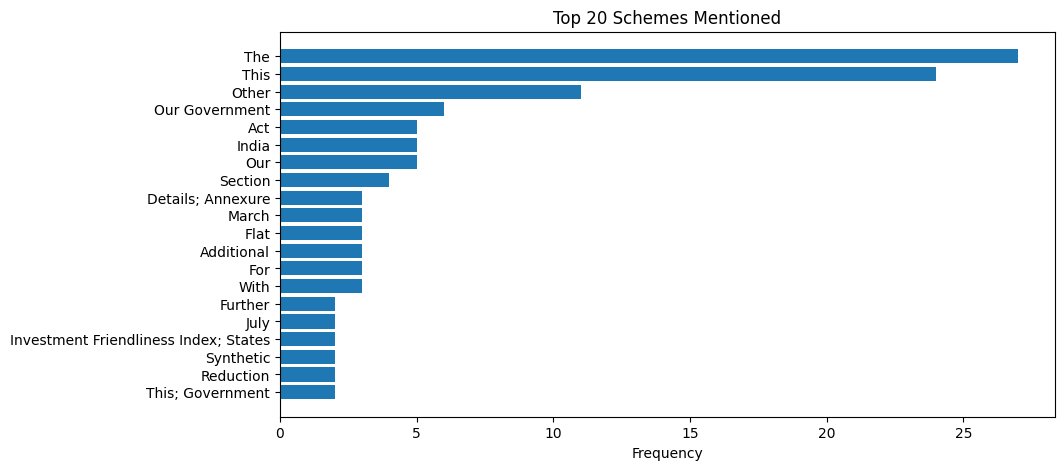

In [38]:
scheme_count = df["schemes"].value_counts().head(20)

plt.figure(figsize=(10,5))
plt.barh(scheme_count.index, scheme_count.values)
plt.title("Top 20 Schemes Mentioned")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.show()


(np.float64(-0.5), np.float64(999.5), np.float64(399.5), np.float64(-0.5))

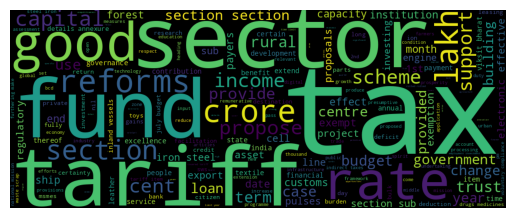

In [39]:
from wordcloud import WordCloud

all_keywords = " ".join(df["top_keywords"].dropna().astype(str))
wc = WordCloud(width=1000, height=400).generate(all_keywords)

plt.imshow(wc)
plt.axis("off")
